# 0 - Imports

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np

import spacy
from transformers import AutoTokenizer

In [2]:
train_df = pd.read_csv("../data/train.csv") # chargement des données d'entraînement
train_df = train_df.set_index("id")
train_df.entities = train_df.entities.apply(json.loads) # parsing des entités
train_df.relations = train_df.relations.apply(json.loads) # parsing des relations
train_df.head()

,text,entities,relations
id,,,
181,"Anam Destresse, président de l'ONG ""Ma passion...","[{'id': 0, 'mentions': [{'value': 'accident', ...","[[0, STARTED_IN, 9], [7, IS_LOCATED_IN, 9], [5..."
31669,"À Paris, le 8 avril 2022, l'usine de déodorant...","[{'id': 0, 'mentions': [{'value': 'explosé', '...","[[9, IS_LOCATED_IN, 8], [11, OPERATES_IN, 8], ..."
51470,"En Espagne, dans une région agricole, une cont...","[{'id': 0, 'mentions': [{'value': 'contaminati...","[[7, IS_PART_OF, 8], [9, OPERATES_IN, 1], [0, ..."
51332,Un important incendie a fait des ravages dans ...,"[{'id': 0, 'mentions': [{'value': 'incendie', ...","[[12, IS_IN_CONTACT_WITH, 5], [0, IS_LOCATED_I..."
1131,« Je coule » : onze heures après avoir envoyé ...,"[{'id': 0, 'mentions': [{'value': 'renversé', ...","[[9, IS_LOCATED_IN, 2], [0, START_DATE, 17], [..."


In [3]:
text_181_entity_0 = train_df.loc[181].entities[0] # sélection de la première entité listée pour le texte 181
print(text_181_entity_0) # affichage de la description complète de l'entité
print(text_181_entity_0["mentions"][0]) # affichage de la description de la première mention de l'entité
print(text_181_entity_0["mentions"][0]["value"]) # affichage de la valeur de l'entité

{'id': 0, 'mentions': [{'value': 'accident', 'start': 70, 'end': 78}, {'value': 'accident de circulation', 'start': 100, 'end': 123}, {'value': 'accident', 'start': 275, 'end': 283}], 'type': 'ACCIDENT'}
{'value': 'accident', 'start': 70, 'end': 78}
accident


In [4]:
text_181_relation_0 = train_df.loc[181].relations[0] # sélection de la première relation listée pour le texte 181
print(text_181_relation_0) # affichage de la description complète de la relation
print(text_181_relation_0[0]) # affichage de l'entité source de la relation
print(text_181_relation_0[1]) # affichage du type de la relation
print(text_181_relation_0[2]) # affichage de l'entité cible de la relation

[0, 'STARTED_IN', 9]
0
STARTED_IN
9


# 1 - Observation des repartitions

In [5]:
type_count = {}
for x in train_df.entities :
    for y in x : 
        if y["type"] in type_count :
            type_count[y["type"]] += 1
        else :
            type_count[y["type"]] = 1

print(type_count)

{'ACCIDENT': 296, 'CIVILIAN': 1253, 'MATERIEL': 3978, 'GROUP_OF_INDIVIDUALS': 1841, 'NON_GOVERNMENTAL_ORGANISATION': 753, 'PLACE': 2348, 'TERRORIST_OR_CRIMINAL': 70, 'TIME_EXACT': 741, 'FIRSTNAME': 1177, 'LASTNAME': 1157, 'CATEGORY': 886, 'QUANTITY_EXACT': 229, 'CBRN_EVENT': 141, 'NON_MILITARY_GOVERNMENT_ORGANISATION': 619, 'FIRE': 131, 'COLOR': 89, 'QUANTITY_FUZZY': 348, 'POLLUTION': 33, 'MILITARY': 21, 'GATHERING': 208, 'NATURAL_EVENT': 70, 'LENGTH': 19, 'TIME_FUZZY': 273, 'TIME_MIN': 52, 'TIME_MAX': 24, 'QUANTITY_MIN': 44, 'NATIONALITY': 174, 'STRIKE': 33, 'EPIDEMIC': 59, 'HEIGHT': 13, 'WEIGHT': 38, 'BOMBING': 32, 'NATURAL_CAUSES_DEATH': 22, 'THEFT': 67, 'DEMONSTRATION': 36, 'AGITATING_TROUBLE_MAKING': 21, 'MILITARY_ORGANISATION': 45, 'ELECTION': 28, 'SUICIDE': 23, 'CRIMINAL_ARREST': 72, 'WIDTH': 14, 'TRAFFICKING': 30, 'POLITICAL_VIOLENCE': 27, 'MATERIAL_REFERENCE': 33, 'DRUG_OPERATION': 16, 'CIVIL_WAR_OUTBREAK': 17, 'COUP_D_ETAT': 20, 'INTERGOVERNMENTAL_ORGANISATION': 17, 'ECONOMIC

In [6]:
sum(type_count.values())

17827

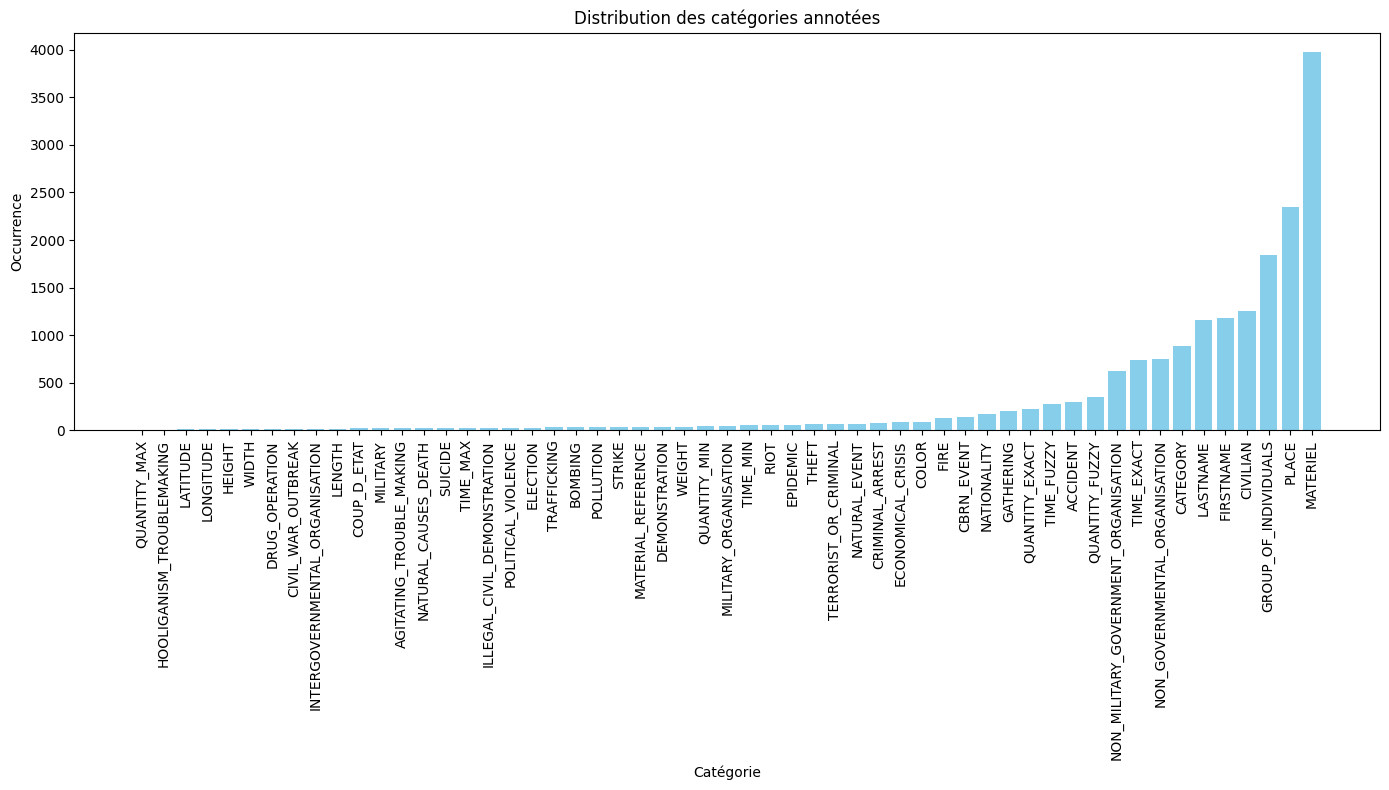

In [ ]:
sorted_type= dict(sorted(type_count.items(), key=lambda item: item[1]))

plt.figure(figsize=(14, 8))
plt.bar(sorted_type.keys(), sorted_type.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Catégorie')
plt.ylabel('Occurrence')
plt.title('Distribution des catégories annotées')
plt.tight_layout()
plt.show()

In [8]:
relations_count = {}
for x in train_df.relations  :
    for y in x : 
        if y[1] in relations_count :
            relations_count[y[1]] += 1
        else :
            relations_count[y[1]] = 1

print(sum(relations_count.values()), relations_count)

31469 {'STARTED_IN': 1860, 'IS_LOCATED_IN': 9025, 'GENDER_FEMALE': 414, 'HAS_CATEGORY': 894, 'IS_DEAD_ON': 68, 'GENDER_MALE': 908, 'START_DATE': 1034, 'END_DATE': 874, 'IS_OF_SIZE': 438, 'OPERATES_IN': 2435, 'HAS_QUANTITY': 191, 'HAS_COLOR': 91, 'IS_PART_OF': 1462, 'CREATED': 126, 'IS_IN_CONTACT_WITH': 2919, 'HAS_CONTROL_OVER': 4547, 'IS_COOPERATING_WITH': 372, 'INITIATED': 469, 'HAS_FOR_LENGTH': 16, 'HAS_CONSEQUENCE': 769, 'WAS_CREATED_IN': 15, 'IS_OF_NATIONALITY': 179, 'IS_AT_ODDS_WITH': 1526, 'HAS_FOR_HEIGHT': 12, 'RESIDES_IN': 222, 'WEIGHS': 41, 'IS_BORN_ON': 20, 'IS_BORN_IN': 50, 'INJURED_NUMBER': 70, 'HAS_FAMILY_RELATIONSHIP': 222, 'HAS_FOR_WIDTH': 14, 'IS_REGISTERED_AS': 34, 'DEATHS_NUMBER': 75, 'WAS_DISSOLVED_IN': 14, 'HAS_LONGITUDE': 12, 'HAS_LATITUDE': 10, 'DIED_IN': 41}


In [9]:
len(relations_count)

37

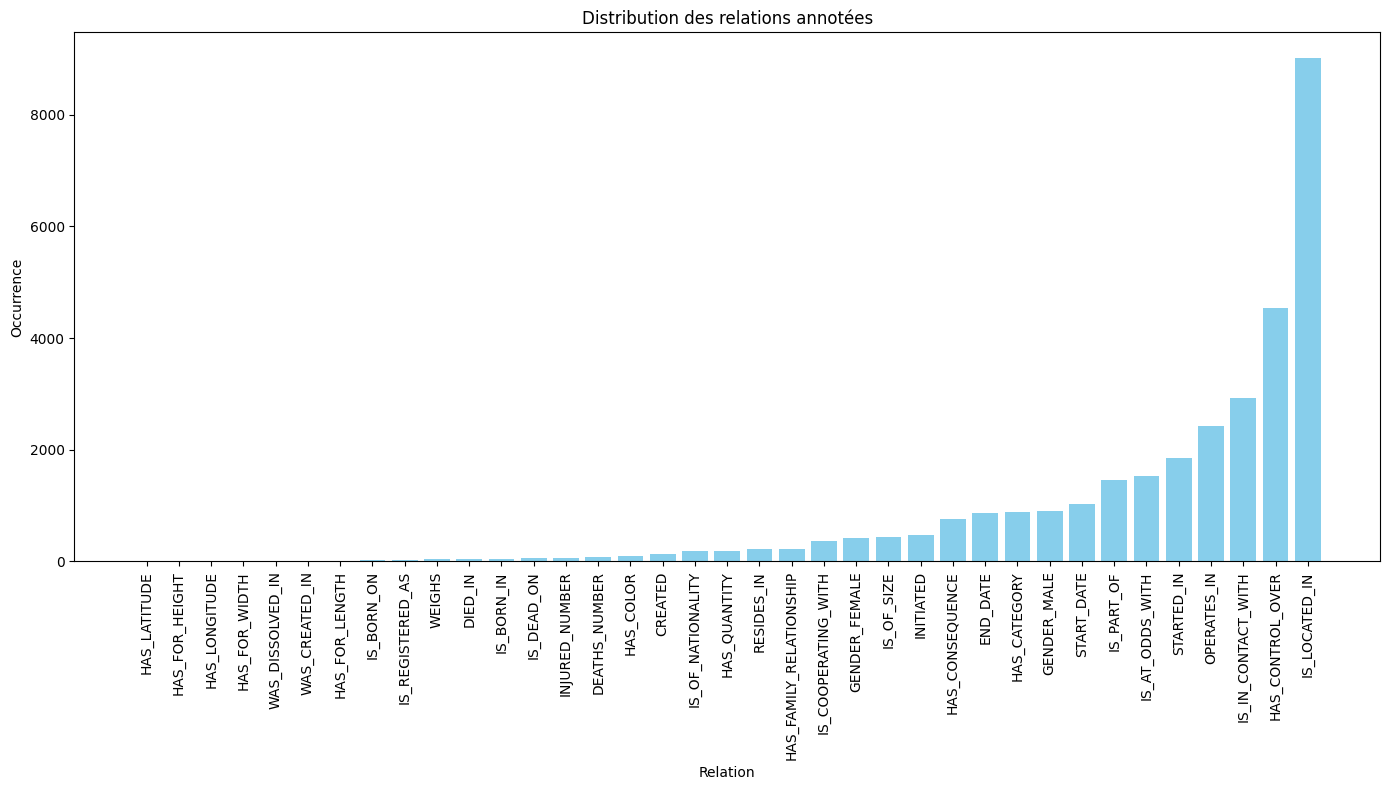

In [ ]:
sorted_relations = dict(sorted(relations_count.items(), key=lambda item: item[1]))

plt.figure(figsize=(14, 8))
plt.bar(sorted_relations.keys(), sorted_relations.values(), color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Relation')
plt.ylabel('Occurrence')
plt.title('Distribution des relations annotées')
plt.tight_layout()
plt.show()

In [11]:
sorted_relations['CREATED']

126

In [ ]:
#python -m spacy download fr_core_news_md
# Charger le modèle français de spaCy
nlp = spacy.load("fr_core_news_md")

def count_sentences_spacy(text):
    doc = nlp(text)
    return len(list(doc.sents))

sent_count = []
sent_count = train_df['text'].apply(count_sentences_spacy)

print(f"Nombre max de phrases : {sent_count.max()}")
print(f"Nombre min de phrases : {sent_count.min()}")
print(f"Nombre médian de phrases : {sent_count.median()}")
print(f"Nombre moyen de phrases : {sent_count.mean()}")

Nombre max de phrases : 15
Nombre min de phrases : 2
Nombre médian de phrases : 6.0
Nombre moyen de phrases : 6.66625


In [10]:
tokenizer = AutoTokenizer.from_pretrained('roberta-large')

In [11]:
# Calculer le nombre de tokens pour chaque texte
train_df['token_count'] = train_df['text'].apply(lambda x: len(tokenizer(x)['input_ids']))

# Filtrer et afficher les textes avec plus de 512 tokens
long_texts = train_df[train_df['token_count'] > 512]
for index, row in long_texts.iterrows():
    print(f"Texte dépassant 512 tokens (index {index}): {row['text']}")

# Calculer le nombre et la proportion des textes dépassant 512 tokens
num_long_texts = len(long_texts)
total_texts = len(train_df)
proportion = num_long_texts / total_texts
# Calculer le nombre de tokens moyen par texte
average_token_count = train_df['token_count'].mean()

# Afficher les résultats
print(f"Nombre de textes dépassant 512 tokens : {num_long_texts}")
print(f"Proportion par rapport au DataFrame entier : {proportion:.2%}")
print(f"Nombre moyen de tokens par texte : {average_token_count:.2f}")

#et ça c'est plutôt une bonne nouvelle

Nombre de textes dépassant 512 tokens : 0
Proportion par rapport au DataFrame entier : 0.00%
Nombre moyen de tokens par texte : 244.67


In [12]:
train_df.loc[181].entities

[{'id': 0,
  'mentions': [{'value': 'accident', 'start': 70, 'end': 78},
   {'value': 'accident de circulation', 'start': 100, 'end': 123},
   {'value': 'accident', 'start': 275, 'end': 283}],
  'type': 'ACCIDENT'},
 {'id': 1,
  'mentions': [{'value': 'Anam Destresse', 'start': 0, 'end': 14},
   {'value': 'Anam Destresse', 'start': 431, 'end': 445}],
  'type': 'CIVILIAN'},
 {'id': 2,
  'mentions': [{'value': 'moto', 'start': 148, 'end': 152},
   {'value': 'moto', 'start': 550, 'end': 554}],
  'type': 'MATERIEL'},
 {'id': 3,
  'mentions': [{'value': 'bus', 'start': 159, 'end': 162},
   {'value': 'bus', 'start': 208, 'end': 211},
   {'value': 'bus', 'start': 589, 'end': 592}],
  'type': 'MATERIEL'},
 {'id': 4,
  'mentions': [{'value': 'panneaux de signalisation',
    'start': 289,
    'end': 314}],
  'type': 'MATERIEL'},
 {'id': 5,
  'mentions': [{'value': 'blessés', 'start': 470, 'end': 477}],
  'type': 'GROUP_OF_INDIVIDUALS'},
 {'id': 6,
  'mentions': [{'value': 'hélicoptère', 'start':

In [13]:
train_df.loc[181].relations

[[0, 'STARTED_IN', 9],
 [7, 'IS_LOCATED_IN', 9],
 [5, 'IS_LOCATED_IN', 10],
 [1, 'GENDER_FEMALE', 1],
 [12, 'IS_LOCATED_IN', 10],
 [0, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 10],
 [13, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 10],
 [1, 'HAS_CATEGORY', 18],
 [5, 'IS_LOCATED_IN', 9],
 [9, 'IS_LOCATED_IN', 10],
 [14, 'IS_DEAD_ON', 15],
 [7, 'HAS_CATEGORY', 19],
 [12, 'IS_LOCATED_IN', 9],
 [0, 'IS_LOCATED_IN', 9],
 [7, 'GENDER_MALE', 7],
 [11, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 9],
 [14, 'IS_LOCATED_IN', 9],
 [14, 'HAS_CATEGORY', 20],
 [0, 'STARTED_IN', 10],
 [0, 'START_DATE', 15],
 [7, 'IS_LOCATED_IN', 10],
 [0, 'END_DATE', 15],
 [14, 'GENDER_MALE', 14],
 [12, 'IS_OF_SIZE', 22],
 [13, 'IS_LOCATED_IN', 10],
 [1, 'IS_LOCATED_IN', 11],
 [13, 'IS_OF_SIZE', 21]]

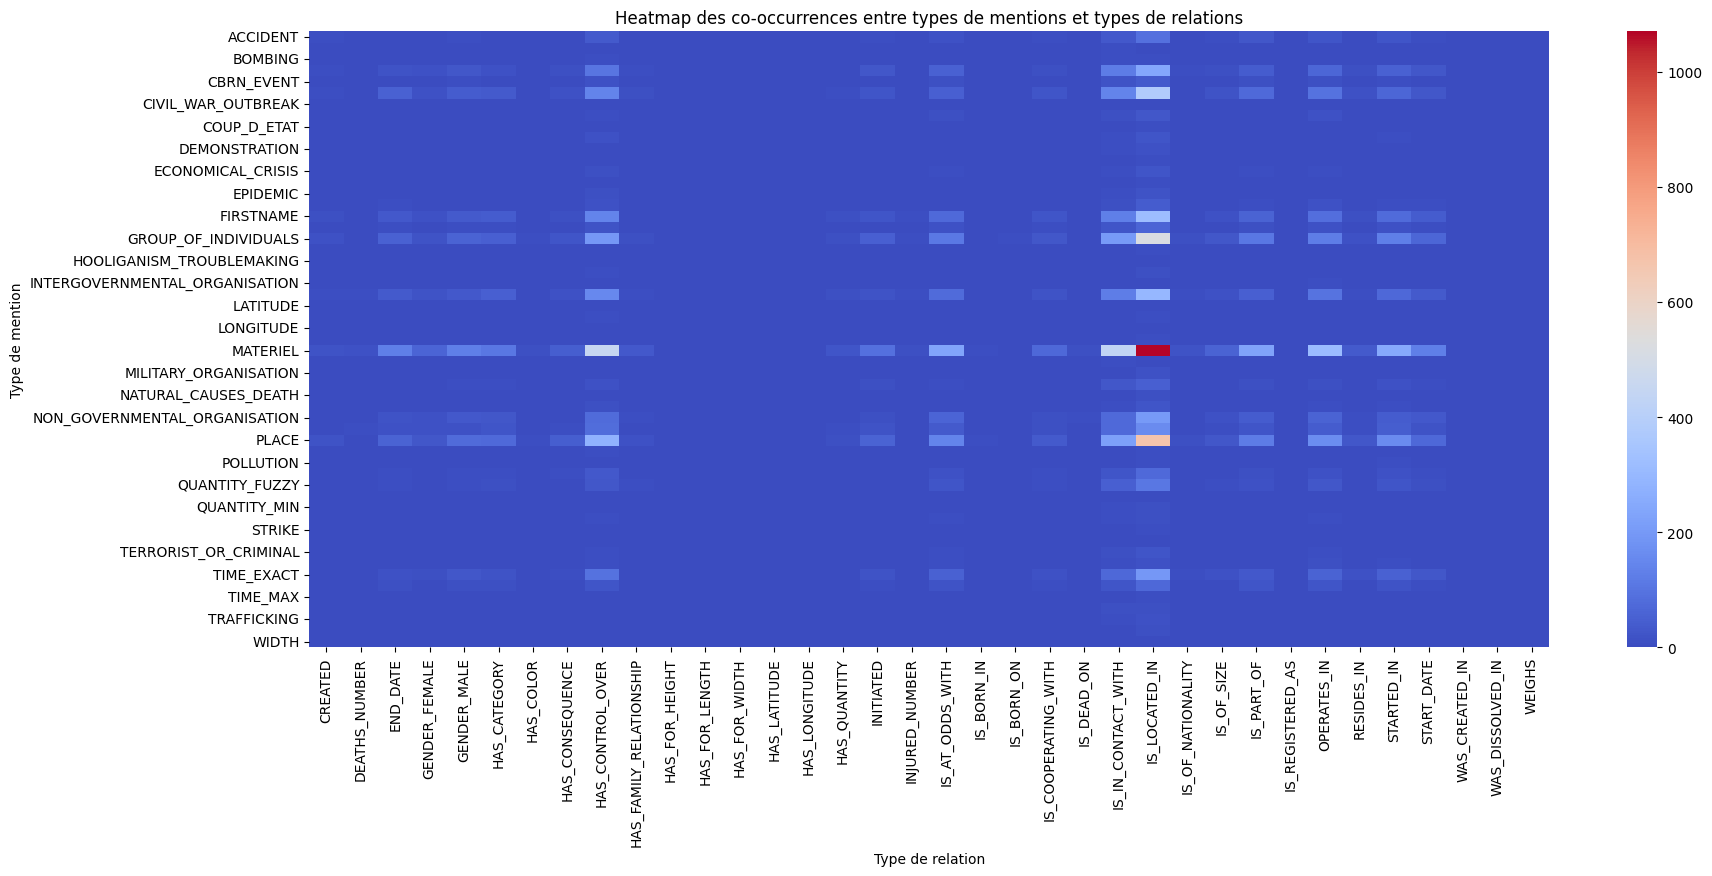

In [ ]:
mention_types = []
relation_types = []

# Type subject_id for predicate (ou A REL) (B étant ignoré)

for index, row in train_df.iterrows():
    for entity in row['entities']:
        mention_types.append(entity['type'])
    for relation in row['relations']:
        relation_types.append(relation[1])

mention_df = pd.DataFrame(mention_types, columns=['mention_type'])
relation_df = pd.DataFrame(relation_types, columns=['relation_type'])

co_occurrence_matrix = pd.crosstab(mention_df['mention_type'], relation_df['relation_type'])

plt.figure(figsize=(20, 8))
sns.heatmap(co_occurrence_matrix, annot=False, fmt="d", cmap="coolwarm", cbar=True)
plt.title('Heatmap des co-occurrences entre types de mentions et types de relations')
plt.xlabel('Type de relation')
plt.ylabel('Type de mention')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


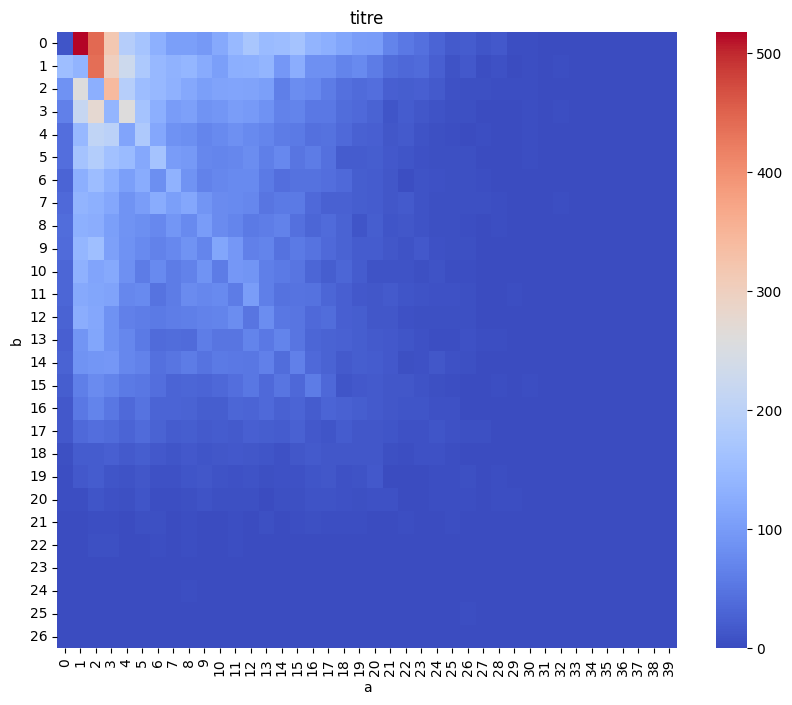

In [15]:
id_A = []
id_B = []

for index, row in train_df.iterrows():
    for relation in row['relations']:
        id_A.append(relation[0])
        id_B.append(relation[-1])

id_A_df = pd.DataFrame(id_A, columns=['id_A'])
id_B_df = pd.DataFrame(id_B, columns=['id_B'])

co_occurrence_matrix = pd.crosstab(id_A_df['id_A'], id_B_df['id_B'])

plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=False, fmt="d", cmap="coolwarm", cbar=True)
plt.title('titre')
plt.xlabel('a')
plt.ylabel('b')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [ ]:
#toutes les combinaisons possibles
out = {}
for index, row in train_df.iterrows():
    for relation in row['relations']:
        relation_type = relation[1]
        idx_A = relation[0]
        idx_B = relation[-1]
        for entity in row['entities']:
            if entity["id"] == idx_A :
                id_A = (entity['type'])
            elif entity["id"] == idx_B:
                id_B = (entity['type'])
        res = (id_A, relation_type, id_B)
        
        if res in out :
            out[res] += 1
        else :
            out[res] = 1

out = {k: v for k, v in sorted(out.items(), key=lambda item: item[1], reverse=True)}
print(len(out), out)

824 {('GROUP_OF_INDIVIDUALS', 'IS_LOCATED_IN', 'PLACE'): 2970, ('CIVILIAN', 'IS_LOCATED_IN', 'PLACE'): 2037, ('PLACE', 'IS_LOCATED_IN', 'PLACE'): 1316, ('NON_MILITARY_GOVERNMENT_ORGANISATION', 'OPERATES_IN', 'PLACE'): 1269, ('GROUP_OF_INDIVIDUALS', 'HAS_CONTROL_OVER', 'MATERIEL'): 1140, ('NON_GOVERNMENTAL_ORGANISATION', 'OPERATES_IN', 'PLACE'): 1061, ('CIVILIAN', 'HAS_CONTROL_OVER', 'MATERIEL'): 1015, ('CIVILIAN', 'HAS_CATEGORY', 'CATEGORY'): 823, ('CIVILIAN', 'IS_IN_CONTACT_WITH', 'GROUP_OF_INDIVIDUALS'): 463, ('GROUP_OF_INDIVIDUALS', 'IS_IN_CONTACT_WITH', 'CIVILIAN'): 463, ('CIVILIAN', 'IS_PART_OF', 'NON_GOVERNMENTAL_ORGANISATION'): 446, ('GROUP_OF_INDIVIDUALS', 'HAS_CONTROL_OVER', 'PLACE'): 440, ('ACCIDENT', 'IS_LOCATED_IN', 'PLACE'): 439, ('CIVILIAN', 'HAS_CONTROL_OVER', 'PLACE'): 432, ('CIVILIAN', 'GENDER_MALE', 'PLACE'): 415, ('ACCIDENT', 'STARTED_IN', 'PLACE'): 404, ('CIVILIAN', 'IS_IN_CONTACT_WITH', 'CIVILIAN'): 354, ('GROUP_OF_INDIVIDUALS', 'IS_IN_CONTACT_WITH', 'GROUP_OF_INDI

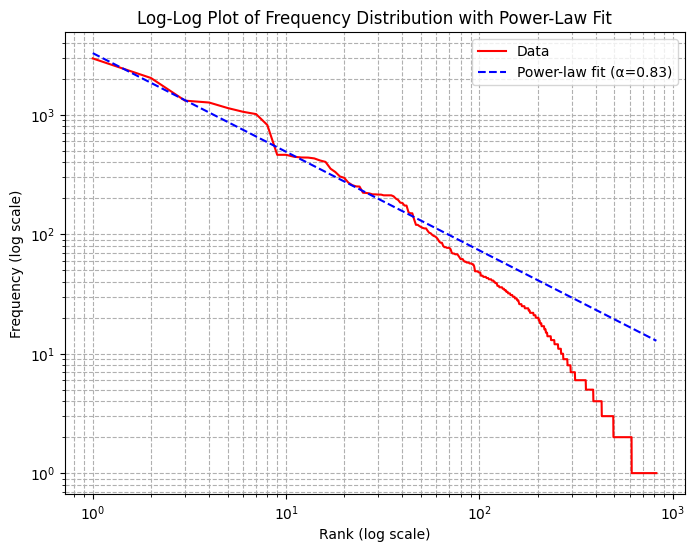

In [ ]:
# Rank (x-axis) and Frequency (y-axis)
ranks = np.arange(1, len(values) + 1)
frequencies = np.array(values)

# Power-law function
def power_law(x, C, alpha):
    return C * x**(-alpha)

# Fit the power-law model
params, _ = curve_fit(power_law, ranks, frequencies)
C, alpha = params

# Generate fitted values for the power-law line
fitted_frequencies = power_law(ranks, C, alpha)

plt.figure(figsize=(8, 6))
plt.loglog(ranks, frequencies, linestyle='-', color='red', label='Data')  # Original data
plt.loglog(ranks, fitted_frequencies, linestyle='--', color='blue', label=f'Power-law fit (α={alpha:.2f})')  # Dashed power-law line
plt.xlabel('Rank (log scale)')
plt.ylabel('Frequency (log scale)')
plt.title('Log-Log Plot of Frequency Distribution with Power-Law Fit')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()